In [14]:
import matplotlib.pyplot as plt

import mysql.connector

conn = mysql.connector.connect(
    host="localhost",
    user="root",        # your MySQL username
    password="rootroot", # your MySQL password
    database="gdb023"    # make sure this database exists
)

cursor = conn.cursor()
print("Connection Successful")



Connection Successful


In [7]:
cursor.execute("SELECT DATABASE();")
db = cursor.fetchone()
print("Connected to database:", db)


Connected to database: ('gdb023',)


In [8]:
cursor.execute("SHOW TABLES;")
tables = cursor.fetchall()

if tables:
    print("Tables in database:")
    for table in tables:
        print(table[0])
else:
    print("No tables found in this database")



Tables in database:
dim_customer
dim_product
fact_gross_price
fact_manufacturing_cost
fact_pre_invoice_deductions
fact_sales_monthly


In [12]:
def sql_query(query):
    return pd.read_sql(query, conn)


C:\Users\manjo\AppData\Local\Temp\ipykernel_25728\1852556731.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


Markets in APAC where Atliq Exclusive operates:
        market
0        India
1    Indonesia
2        Japan
3  Philiphines
4  South Korea
5    Australia
6   Newzealand
7   Bangladesh


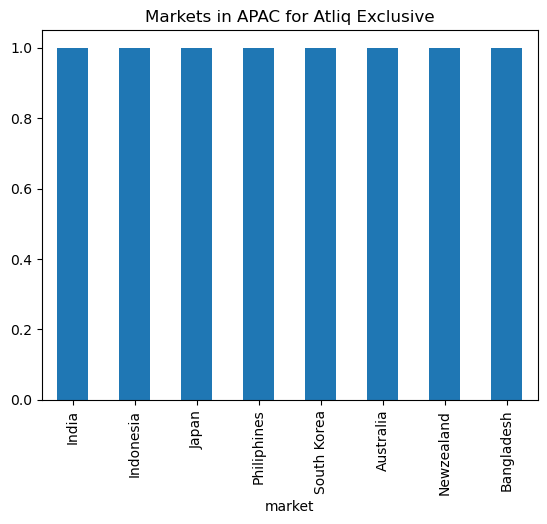

In [15]:
query1 = """
SELECT DISTINCT market
FROM dim_customer
WHERE customer = 'Atliq Exclusive' AND region = 'APAC';
"""
markets_df = sql_query(query1)
print("Markets in APAC where Atliq Exclusive operates:")
print(markets_df)

# Optional visualization
markets_df['market'].value_counts().plot(kind='bar', title='Markets in APAC for Atliq Exclusive')
plt.show()



C:\Users\manjo\AppData\Local\Temp\ipykernel_25728\1852556731.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


   fiscal_year  unique_products  pct_change
0         2020              245         NaN
1         2021              334   36.326531


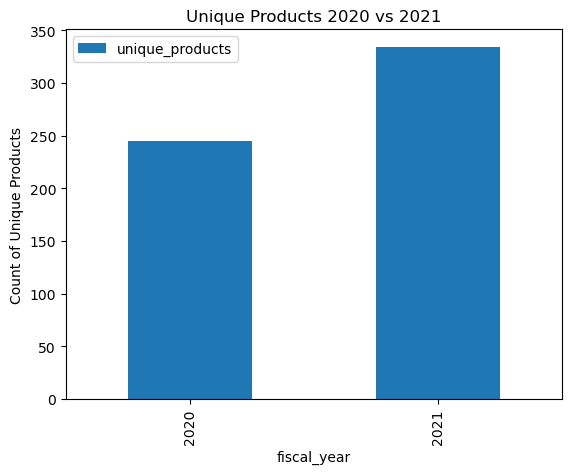

In [16]:
query2 = """
SELECT fiscal_year, COUNT(DISTINCT product_code) AS unique_products
FROM fact_gross_price
WHERE fiscal_year IN (2020, 2021)
GROUP BY fiscal_year
ORDER BY fiscal_year;
"""
prod_counts = sql_query(query2)
prod_counts['pct_change'] = prod_counts['unique_products'].pct_change() * 100
print(prod_counts)

# Visualization
prod_counts.plot(x='fiscal_year', y='unique_products', kind='bar', title='Unique Products 2020 vs 2021')
plt.ylabel('Count of Unique Products')
plt.show()



C:\Users\manjo\AppData\Local\Temp\ipykernel_25728\1852556731.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


       segment  unique_products
0     Notebook              129
1  Accessories              116
2  Peripherals               84
3      Desktop               32
4      Storage               27
5   Networking                9


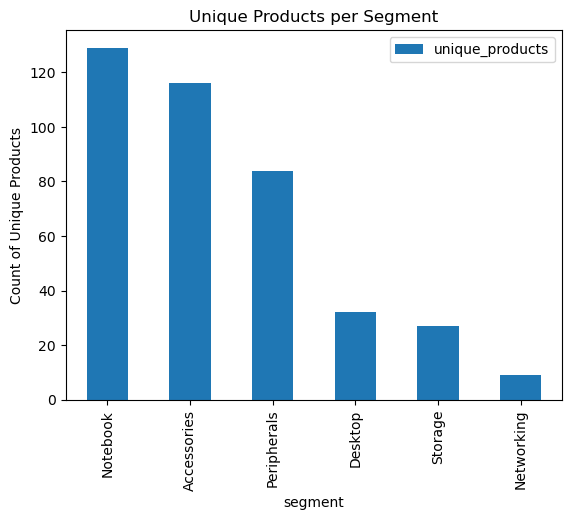

In [17]:
query3 = """
SELECT segment, COUNT(DISTINCT product_code) AS unique_products
FROM dim_product
GROUP BY segment
ORDER BY unique_products DESC;
"""
segment_counts = sql_query(query3)
print(segment_counts)

# Visualization
segment_counts.plot(x='segment', y='unique_products', kind='bar', title='Unique Products per Segment')
plt.ylabel('Count of Unique Products')
plt.show()


In [18]:
query4 = """
SELECT p.segment,
       SUM(CASE WHEN g.fiscal_year=2020 THEN 1 ELSE 0 END) AS count_2020,
       SUM(CASE WHEN g.fiscal_year=2021 THEN 1 ELSE 0 END) AS count_2021
FROM dim_product p
JOIN fact_gross_price g ON p.product_code = g.product_code
GROUP BY p.segment;
"""
segment_diff = sql_query(query4)
segment_diff['increase'] = segment_diff['count_2021'] - segment_diff['count_2020']
max_increase_segment = segment_diff.loc[segment_diff['increase'].idxmax()]
print("Segment with highest increase in unique products from 2020 to 2021:")
print(max_increase_segment)


Segment with highest increase in unique products from 2020 to 2021:
segment       Accessories
count_2020           69.0
count_2021          103.0
increase             34.0
Name: 1, dtype: object


C:\Users\manjo\AppData\Local\Temp\ipykernel_25728\1852556731.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


In [19]:
query5 = """
SELECT p.product_code, p.product, m.manufacturing_cost
FROM dim_product p
JOIN fact_manufacturing_cost m ON p.product_code = m.product_code
WHERE m.manufacturing_cost = (SELECT MAX(manufacturing_cost) FROM fact_manufacturing_cost)
   OR m.manufacturing_cost = (SELECT MIN(manufacturing_cost) FROM fact_manufacturing_cost);
"""
prod_cost_extremes = sql_query(query5)
print(prod_cost_extremes)


  product_code                product  manufacturing_cost
0  A2118150101  AQ Master wired x1 Ms              0.8920
1  A6120110206   AQ HOME Allin1 Gen 2            240.5364


C:\Users\manjo\AppData\Local\Temp\ipykernel_25728\1852556731.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


C:\Users\manjo\AppData\Local\Temp\ipykernel_25728\1852556731.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


      customer  avg_discount
0     Flipkart        0.3083
1       Viveks        0.3038
2        Ezone        0.3028
3        Croma        0.3025
4  Vijay Sales        0.2753


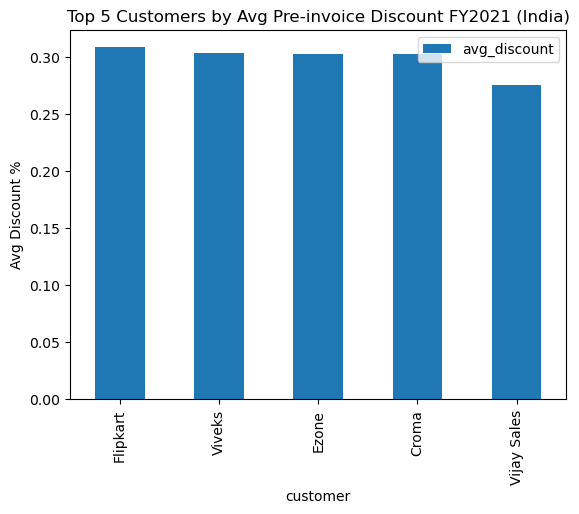

In [20]:
query6 = """
SELECT c.customer, AVG(f.pre_invoice_discount_pct) AS avg_discount
FROM fact_pre_invoice_deductions f
JOIN dim_customer c ON f.customer_code = c.customer_code
WHERE f.fiscal_year = 2021 AND c.sub_zone = 'India'
GROUP BY c.customer
ORDER BY avg_discount DESC
LIMIT 5;
"""
top_customers_discount = sql_query(query6)
print(top_customers_discount)

# Visualization
top_customers_discount.plot(x='customer', y='avg_discount', kind='bar', title='Top 5 Customers by Avg Pre-invoice Discount FY2021 (India)')
plt.ylabel('Avg Discount %')
plt.show()


C:\Users\manjo\AppData\Local\Temp\ipykernel_25728\1852556731.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


    year  month   gross_sales
0   2019      9  4.496260e+06
1   2019     10  5.135902e+06
2   2019     11  7.522893e+06
3   2019     12  4.830405e+06
4   2020      1  4.740600e+06
5   2020      2  3.996228e+06
6   2020      3  3.787710e+05
7   2020      4  3.950354e+05
8   2020      5  7.838134e+05
9   2020      6  1.695217e+06
10  2020      7  2.551159e+06
11  2020      8  2.786648e+06
12  2020      9  1.235351e+07
13  2020     10  1.321864e+07
14  2020     11  2.046500e+07
15  2020     12  1.294466e+07
16  2021      1  1.239939e+07
17  2021      2  1.012974e+07
18  2021      3  1.214406e+07
19  2021      4  7.312000e+06
20  2021      5  1.215023e+07
21  2021      6  9.824521e+06
22  2021      7  1.209235e+07
23  2021      8  7.178708e+06


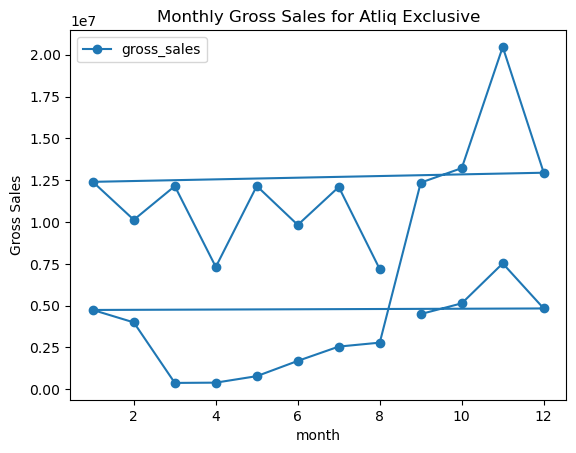

In [21]:
query7 = """
SELECT YEAR(s.date) AS year,
       MONTH(s.date) AS month,
       SUM(s.sold_quantity * g.gross_price) AS gross_sales
FROM fact_sales_monthly s
JOIN fact_gross_price g ON s.product_code = g.product_code AND s.fiscal_year = g.fiscal_year
JOIN dim_customer c ON s.customer_code = c.customer_code
WHERE c.customer = 'Atliq Exclusive'
GROUP BY YEAR(s.date), MONTH(s.date)
ORDER BY year, month;
"""
monthly_sales = sql_query(query7)
print(monthly_sales)

# Visualization
monthly_sales.plot(x='month', y='gross_sales', kind='line', marker='o', title='Monthly Gross Sales for Atliq Exclusive')
plt.ylabel('Gross Sales')
plt.show()


In [22]:
query8 = """
SELECT QUARTER(date) AS quarter, SUM(sold_quantity) AS total_sold_quantity
FROM fact_sales_monthly
WHERE fiscal_year = 2020
GROUP BY QUARTER(date)
ORDER BY total_sold_quantity DESC
LIMIT 1;
"""
max_quarter_2020 = sql_query(query8)
print("Quarter of 2020 with maximum sold quantity:")
print(max_quarter_2020)


C:\Users\manjo\AppData\Local\Temp\ipykernel_25728\1852556731.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


Quarter of 2020 with maximum sold quantity:
   quarter  total_sold_quantity
0        4            8425822.0


In [23]:
query9 = """
SELECT c.channel, SUM(s.sold_quantity * g.gross_price) AS total_sales
FROM fact_sales_monthly s
JOIN fact_gross_price g ON s.product_code = g.product_code AND s.fiscal_year = g.fiscal_year
JOIN dim_customer c ON s.customer_code = c.customer_code
WHERE s.fiscal_year = 2021
GROUP BY c.channel
ORDER BY total_sales DESC
LIMIT 1;
"""
top_channel = sql_query(query9)
total_sales_2021 = sql_query("""
SELECT SUM(s.sold_quantity * g.gross_price) AS total_sales
FROM fact_sales_monthly s
JOIN fact_gross_price g ON s.product_code = g.product_code AND s.fiscal_year = g.fiscal_year
WHERE s.fiscal_year = 2021;
""")['total_sales'][0]

top_channel['pct_contribution'] = top_channel['total_sales'] / total_sales_2021 * 100
print(top_channel)


C:\Users\manjo\AppData\Local\Temp\ipykernel_25728\1852556731.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


    channel   total_sales  pct_contribution
0  Retailer  1.219082e+09         73.233983


In [24]:
query10 = """
SELECT p.division, p.product, SUM(s.sold_quantity) AS total_sold_quantity
FROM fact_sales_monthly s
JOIN dim_product p ON s.product_code = p.product_code
WHERE s.fiscal_year = 2021
GROUP BY p.division, p.product
ORDER BY p.division, total_sold_quantity DESC;
"""
division_products = sql_query(query10)

# Rank top 3 per division
division_products['rank'] = division_products.groupby('division')['total_sold_quantity'].rank(method='first', ascending=False)
top3_division_products = division_products[division_products['rank'] <= 3].sort_values(['division','rank'])
print(top3_division_products)


C:\Users\manjo\AppData\Local\Temp\ipykernel_25728\1852556731.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


   division                   product  total_sold_quantity  rank
0     N & S          AQ Pen Drive DRC            2034569.0   1.0
1     N & S              AQ Digit SSD            1240149.0   2.0
2     N & S                   AQ Clx1            1238683.0   3.0
10    P & A              AQ Gamers Ms            2477098.0   1.0
11    P & A              AQ Maxima Ms            2461991.0   2.0
12    P & A  AQ Master wireless x1 Ms            2448784.0   3.0
49       PC                  AQ Digit             135092.0   1.0
50       PC                  AQ Gen Y             135031.0   2.0
51       PC                  AQ Elite             134431.0   3.0
